In [7]:
import pandas as pd
df = pd.read_csv('train_test_network.csv', encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211043 entries, 0 to 211042
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   src_ip                  211043 non-null  object 
 1   src_port                211043 non-null  int64  
 2   dst_ip                  211043 non-null  object 
 3   dst_port                211043 non-null  int64  
 4   proto                   211043 non-null  object 
 5   service                 211043 non-null  object 
 6   duration                211043 non-null  float64
 7   src_bytes               211043 non-null  int64  
 8   dst_bytes               211043 non-null  int64  
 9   conn_state              211043 non-null  object 
 10  missed_bytes            211043 non-null  int64  
 11  src_pkts                211043 non-null  int64  
 12  src_ip_bytes            211043 non-null  int64  
 13  dst_pkts                211043 non-null  int64  
 14  dst_ip_bytes        

In [8]:
# df.head()
# for col in df.select_dtypes(include='object').columns:
#     print(f"{col}: {df[col].nunique()} unique values")
df.dtypes

src_ip                     object
src_port                    int64
dst_ip                     object
dst_port                    int64
proto                      object
service                    object
duration                  float64
src_bytes                   int64
dst_bytes                   int64
conn_state                 object
missed_bytes                int64
src_pkts                    int64
src_ip_bytes                int64
dst_pkts                    int64
dst_ip_bytes                int64
dns_query                  object
dns_qclass                  int64
dns_qtype                   int64
dns_rcode                   int64
dns_AA                     object
dns_RD                     object
dns_RA                     object
dns_rejected               object
ssl_version                object
ssl_cipher                 object
ssl_resumed                object
ssl_established            object
ssl_subject                object
ssl_issuer                 object
http_trans_dep

In [ ]:
import pandas as pd
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from scipy.stats import mode
import time
from joblib import dump, load
import os
from scipy.stats import mode
from tqdm import tqdm
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
    

SEED = 42
NUM_FEATURES = 13

In [10]:
categorical_cols = df.select_dtypes(include='object').columns
label_encoders = {}

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"\nColumn: {col}")
    print(dict(zip(le.classes_, le.transform(le.classes_))))

feature_names = df.columns

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
print(f"Original class distribution: {np.bincount(y_train)}")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca = PCA(n_components=NUM_FEATURES, random_state=SEED)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test_scaled)

print("Features Selected: ")
for i, component in enumerate(pca.components_):
    # Get the index of the feature with the largest absolute value in this component
    important_idx = np.argmax(np.abs(component))
    print(f"Principal Component {i+1}: most important feature is '{feature_names[important_idx]}'")


X_train = X_train_pca
X_test = X_test_pca

print(X_train.shape)
print(X_test.shape)



Column: src_ip
{'13.55.50.68': 0, '172.17.0.5': 1, '172.17.0.7': 2, '172.17.0.8': 3, '192.168.1.1': 4, '192.168.1.103': 5, '192.168.1.133': 6, '192.168.1.152': 7, '192.168.1.169': 8, '192.168.1.17': 9, '192.168.1.180': 10, '192.168.1.184': 11, '192.168.1.186': 12, '192.168.1.190': 13, '192.168.1.191': 14, '192.168.1.192': 15, '192.168.1.193': 16, '192.168.1.194': 17, '192.168.1.195': 18, '192.168.1.250': 19, '192.168.1.30': 20, '192.168.1.31': 21, '192.168.1.32': 22, '192.168.1.33': 23, '192.168.1.34': 24, '192.168.1.36': 25, '192.168.1.37': 26, '192.168.1.38': 27, '192.168.1.39': 28, '192.168.1.46': 29, '192.168.1.49': 30, '192.168.1.6': 31, '192.168.1.79': 32, '199.115.158.193': 33, '203.14.129.10': 34, '220.158.215.20': 35, '2405:6e00:10ce:2c00:20c:29ff:fed2:b002': 36, '2405:6e00:10ce:2c00:20c:29ff:feee:e07a': 37, '2405:6e00:10ce:2c00:8520:4eba:6770:702a': 38, '2405:6e00:10ce:2c00:9064:17:85d2:57d4': 39, '2405:6e00:10ce:2c00:c058:dbaa:f212:a2d8': 40, 'fe80::1087:c341:7263:ead3': 41

In [11]:
from joblib import dump, load

# dump(scaler, 'scaler.joblib')
# dump(pca, 'pca.joblib')
dump(label_encoders, 'label_encoders.joblib')
# dump(categorical_cols, 'categorical_cols.joblib')
# dump(feature_names, 'feature_names.joblib')

['label_encoders.joblib']

In [12]:
n_layers = 7

dev = qml.device("default.qubit", wires=NUM_FEATURES)

@qml.qnode(dev)
def qnn_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(NUM_FEATURES))
    qml.StronglyEntanglingLayers(weights, wires=range(NUM_FEATURES))
    return [qml.expval(qml.PauliZ(i)) for i in range(NUM_FEATURES)]

qnode = qml.QNode(qnn_circuit, dev, interface="torch")

class QNNClassifier(nn.Module):
    def __init__(self, n_layers, n_qubits):
        super().__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.fc = nn.Linear(n_qubits, 1)
    
    def forward(self, x):
        x = self.qlayer(x)
        x = self.fc(x)
        return x  # No sigmoid here

<generator object Module.parameters at 0x7f4a3f48c4a0>
Epoch 10/100, Loss: 0.0561
Epoch 20/100, Loss: 0.0391
Epoch 30/100, Loss: 0.0337
Epoch 40/100, Loss: 0.0255
Epoch 50/100, Loss: 0.0255
Epoch 60/100, Loss: 0.0226
Epoch 70/100, Loss: 0.0212
Epoch 80/100, Loss: 0.0227
Epoch 90/100, Loss: 0.0196
Epoch 100/100, Loss: 0.0177
QNN Accuracy on Test Data: 0.9920
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       252
           1       0.99      1.00      0.99       748

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



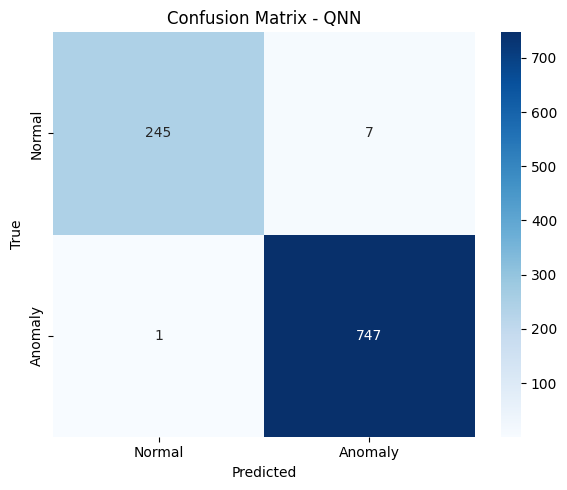

In [13]:
X_train_300 = X_train[:3000]
X_test_100 = X_test[:1000]
y_train_300 = y_train[:3000]
y_test_100 = y_test[:1000]

loss_values = []

# Prepare data
X_train_tensor = torch.tensor(X_train_300, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_300.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_100, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_100.values, dtype=torch.float32).unsqueeze(1)

# Use DataLoader for mini-batch training
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, loss, optimizer
model = QNNClassifier(n_layers=n_layers, n_qubits=NUM_FEATURES)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
print(model.parameters())

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
# with torch.no_grad():
#     y_pred_logits = model(X_test_tensor)
#     qnn_preds = (torch.sigmoid(y_pred_logits) > 0.5).int().squeeze().numpy()

with torch.no_grad():
    y_pred_logits = model(X_test_tensor)  # shape: (N, 1)
    qnn_sigmoid = torch.sigmoid(y_pred_logits).squeeze()  # shape: (N,)
    qnn_preds = (qnn_sigmoid > 0.5).int().numpy()

    # Convert to probability distribution over 2 classes: [P(class 0), P(class 1)]
    qnn_probs = torch.stack([1 - qnn_sigmoid, qnn_sigmoid], dim=1).cpu().numpy()  # shape: (N, 2)


accuracy_qnn = accuracy_score(y_test_100, qnn_preds)
print(f"QNN Accuracy on Test Data: {accuracy_qnn:.4f}")

print("Classification Report:\n", classification_report(y_test_100, qnn_preds))

cm = confusion_matrix(y_test_100, qnn_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix - QNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

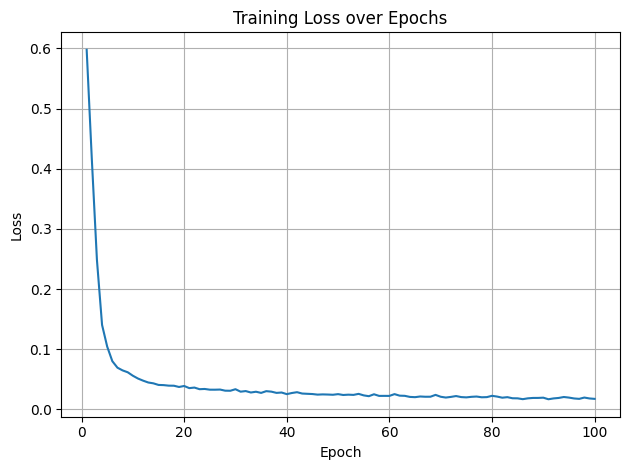

In [15]:
plt.plot(range(1, epochs + 1), loss_values, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name} grad mean: {param.grad.mean().item():.6f}")


qlayer.weights grad mean: -0.000336
fc.weight grad mean: -0.000128
fc.bias grad mean: -0.002937


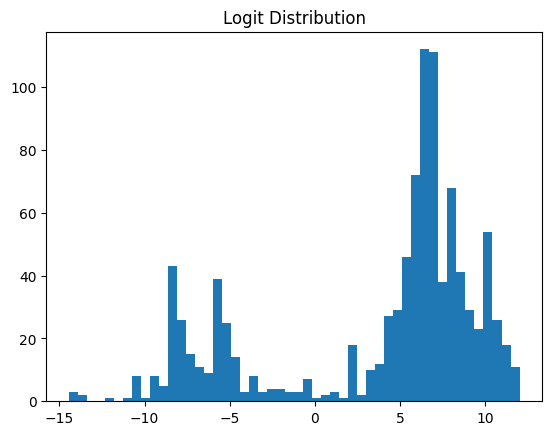

In [17]:
plt.hist(y_pred_logits.numpy(), bins=50)
plt.title("Logit Distribution")
plt.show()


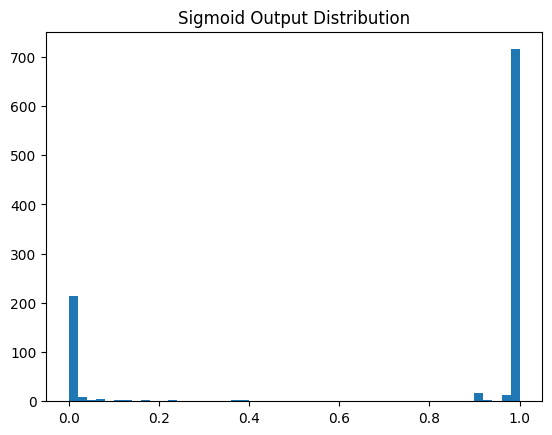

In [18]:
plt.hist(qnn_sigmoid.numpy(), bins=50)
plt.title("Sigmoid Output Distribution")
plt.show()


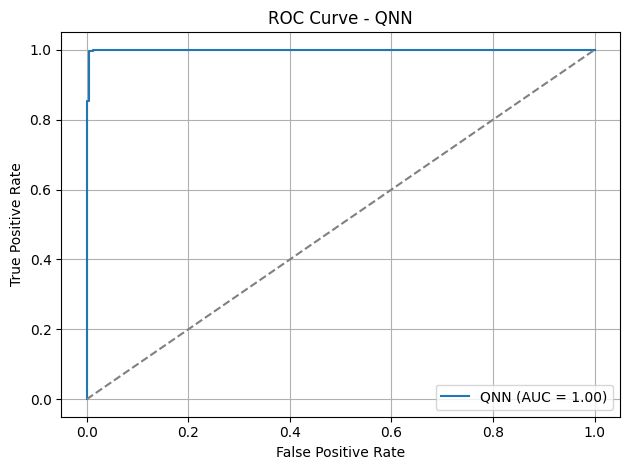

In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_100, qnn_sigmoid.numpy())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'QNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - QNN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()